# flowField class for iterative solution

## Contents
- Subclass of numpy.ndarray()

### Basic flow descriptors
Define as a dictionary:
* $ \alpha, \beta $  describing the periodicity, and $Re$
* K,L,M,N describing the resolution:
    - K: No. of temporal frequencies
    - L: No. of positive streamwise Fourier modes
    - M: No. of positive spanwise Fourier modes
    - N: No. of Chebyshev collocation nodes in wall-normal 
    - The total size of each variable would be (2L+1)(2M+1)N
* Flow type: Couette or Poiseuille (use flags)- default to Couette
    - Boundary conditions on $u_0$
    - dPdx
    
### Values
* The classes are a subclass of np.ndarray. So the values of the flowField can be directly accessed through the name of the instance. But this is not recommended unless one's absolutely sure about what they're doing. Class methods should be used as much as possible, and if doing something with the arrays outside of the methods, the accompanying dictionaries should also be appropriately modified.
    - Store only fluctuations
    - Define a separate $u_{base}$ based on `isPois` when the base flow is needed. 


### Methods to be defined
* Viewers: 
    - self.view1d(): 1D array for state
    - self.view4d(): 4D array (streamwise, spanwise, variable ID, wall-normal)
* Verification:  self.verify()
    - Check that the dictionary `flowDict` has all the required parameters
    - Check that the parameters are consistent with the size of the np.ndarray
    - Check that appropriate modes are complex conjugates
* Slicing: self.slice()
    - Return only a subset of Fourier modes (centered at (K,L,M) = (0,0,0) )
    - Extend the flowField by adding zero modes for higher wavenumbers
* Dot product of flow fields: chi1.dot(chi2)
    - Defined as $\int_0^T\int_\forall (u_1\bar{u_2} + v_1 \bar{v_2} + w_1 \bar{w_2}) dx dy dz dt$ 
    - Optional parameter to include the fourth field variable in the integration
* Norm: self.norm()
    - self.norm() = sqrt( self.dot(self)) 
* physical: self.physical(fileName)
    - Print field on Cartesian coordinates to file
    - Set defaults for optional parameters `xsteps,ysteps,zsteps,tsteps` based on number of Fourier and Chebyshev modes in the flowField. Prints fields at different times to different files
    
## Inputs
* Flow descriptors (see above)
    - Keep $ \alpha, \beta, Re$ as optional parameters, default values being those used in ChannelFlow: (1.14,2.5,400)
    * Resolution: L,M,N    
* Base flow type (flag):
    - Either linear, or quadratic. Assume linear as default. 
* Read from file- optional (flag):
    - Filename, format ('mat', 'npy', 'asc',...)
* Noise levels (default to zero):
    - Add random noise to the state vector whose norm is that as input.

## Tests for class
* Ensure that solving for flat-walled Couette and Poiseuille flows using direct inversion works
* Ensure that the above cases work with iterative solver. 

### Other notes to self:
* Write doc-strings for all the methods and inputs
* When initializing flowField as white-noise, think about smoothening the noise. Do this by using random coefficients for fields in Chebyshev spectral, and then transform to collocation nodes. Put more of the energy into lower Cheb modes and lower Fourier modes. 


## Collaborator comments
Use this cell for comments

---------------------------------------------------

## Inheriting numpy.ndarray()

Reference: http://docs.scipy.org/doc/numpy/user/basics.subclassing.html

In [ ]:
import numpy as np

class C(np.ndarray): pass

arr = np.zeros(3,)
c_arr = arr.view(C)

print(type(arr))
print(type(c_arr))
print(c_arr)



In [ ]:
v= c_arr[:]
print(type(v))

v is c_arr


In [ ]:
print(type(v))

In [ ]:
print(dir())

In [ ]:
print(c_arr)
v[1]=5.
print(c_arr)

In [ ]:
v == c_arr

Need to be careful when using `is`. It refers to the IDs of objects. If using arrays or elements of arrays, using `is` is a bad idea. Stick to `==` when comparing numerical values- which is usually all I care for.

In [ ]:
gen = np.zeros(3,)
v1 = gen[:]
print(v1 is gen)
v1[1]=3.
print(gen)
print(gen[:] is gen)
print(id(gen))
print(id(gen[:]))
v2 = gen
print (v2 is gen)
print (id(v2))
print(v1 == gen)
print (v1[0] is gen[0])

## Reading files into dictionary


In [ ]:
ls


In [ ]:
%cat flowConfig.txt

In [ ]:
flowDict = {}
with open("flowConfig.txt",'r') as f:
    for line in f:
        (key,val) = line.split()[:2]
        flowDict[key] = float(val)


In [ ]:
defaultDict = {'alpha':1.14, 'beta' : 2.5, 'omega':0.0, 'L': 0.0, 'M': 0.0, 'N': 0.0, 'K':0.0,
               'ReLam': 400.0, 'isPois':0.0, 'noise':0.0 , 'testvar':5.5}
for key in defaultDict:
    if key not in flowDict:
        flowDict[key] = defaultDict[key]
        print(key,flowDict[key],type(flowDict[key]))

In [ ]:
print(flowDict)
print( 2.5+flowDict['alpha'])

In [ ]:
flowDict['alpha'],flowDict['beta']
print (2+float(flowDict['alpha']))
print(flowDict.values)
float(flowDict['beta'])

flowDict['alpha'] = float(flowDict['alpha'])
flowDict['alpha']+2.5

## Defining flowField class that inherits np.ndarray

For starters, defining the class to initialize an empty ndarray along with a dictionary provided during initialization.

I need to verify that the dictionary being supplied has all the info I need to go with a flowField class. But, I can't verify this all the time. This is how I'll deal with it: 
* Verify the dictionary only when constructing a flowField class. So, that's when
    - Explicitly constructing an instance of the class
    - Viewing a given array as an instance of the class
* When slicing an array of the flowField class (to obtain another instance of the class), don't bother with the check. 

Basically, ensure every instance of the flowField class has a valid dictionary, and then stop worrying about it. 

So, we need a function that verifies the validity of dictionary, or creates one if one isn't supplied. The parameters required in the dictionary, and their defaults, are as follows:
* alpha : 1.14    
    *Wavenumber of fundamental streamwise Fourier mode*
* beta :  2.5    
    *Wavenumber of fundamental spanwise Fourier mode*
* omega: 0.0    
    *Fundamental frequency*
* ReLam: 400.0  
    *Reynolds number of the laminar base flow*
* isPois: 0     
    *Flag for base flow type. 0: Couette, 1: Poiseuille*
* noise: 0.0    
    *Norm of noise to be added to the flow*
* L: 0          
    *Number of (positive) harmonics of fundamental streamwise Fourier mode.*
* M: 0          
    *Number of (positive) harmonics of fundamental spanwise Fourier mode*
* N: 35         
    *Number of Chebyshev collocation nodes*
* K: 0         
    *Number of (positive) harmonics of fundamental frequency*

** For now, I'm ignoring the fact that np.ndarray can be viewed as a subclass. I'm defining the dictionary and checks in flowField.__new__(). Later, I'll have to move this to __array_finalize__ so that the dictionary is defined for cases when either an explicit constructor call is made or a view-casting is done**

### Ensure these features:
* View-casting:
    - ** View-casting a np.ndarray as flowField instance is not supported. Because view-casting does not allow any arguments, and the dictionary that accompanies the flowField array is fundamental. To make a flowField object out of an existing np.ndarray, use the constructor call. **
* Explicit construction:
    - Construct a randomField object based on noise levels supplied
* New from template:
    - Truncate and expand an instance of flowField to obtain a new instance with a changed dictionary (to reflect the truncation of L,M,N, or K)

***Try to minimize making copies of flowField objects***

** I have three cases to consider when building a flowField instance. Suppose L = 1**:
- The flowField has streamwise wavenumbers $-\alpha, 0, \alpha$
- The flowField only has streamwise wavenumbers $-\alpha, \alpha$
- The flowField only has streamwise wavenumber $\alpha$
    
This question becomes particularly important if only a half-plane or half-volume of the wavenumber space is considered. 

This is how I chose to resolve this issue. Considering L:
* If L = 0, then the flowField is of wavenumber $\alpha$
* If L = n ($\in \mathbb{N}$), then the flowField is resolved in wavenumbers {$0,\alpha,2\alpha,..,n\alpha$}.
* If L = -n ($n \in \mathbb{N}$), then the flowField is resolved in wavenumbers {$-n\alpha, (-n+1)\alpha,..,0,\alpha,...,n\alpha$}

This way, a flowField can be defined in three different ways for each of the three Fourier axes (streamwise, spanwise, temporal):
* As just one Fourier mode, $\alpha$ (which could be positive, negative, or zero). 
* As a collection of `n` harmonics (positive integer multiples of a positive/negative wavenumber), along with mode zero (the invariant mode).
* As a collection of `2n+1` harmonics, from $-n\alpha$ through $n\alpha$.

** Correction: For streamwise and temporal Fourier modes, the flowField class does not allow having just positive modes. We either have just one wavenumber (initialized with L=0 and/or K=0), of have 2L+1 and 2K+1 wavenumbers with both positive and negative**

I think this should be enough to deal with most cases. We will later need to define collections of flowFields. 

In [ ]:
# In case dictionary is 'None':
defaultDict = {'alpha':1.14, 'beta' : 2.5, 'omega':0.0, 'L': 0.0, 'M': 0.0, 'N': 0.0, 'K':0.0,
               'ReLam': 400.0, 'isPois':0.0, 'noise':0.0 }

def verify_dict(tempDict):
    if tempDict is None:
        tempDict = defaultDict
    else: 
        for key in defaultDict:
            if key not in tempDict:
                tempDict[key] = defaultDict[key]
    return tempDict

flowDict = None
flowDict = verify_dict(flowDict)
print(flowDict)

## Slice
I'm defining `slice` as a general method used for either truncating or extending the existing flowField instance. 

There are several cases to consider:
1.  Both existing and requested instances have the same wavenumber extension: either both contain positive and negative wavenumbers, or both contain only non-negative wavenumbers. For this case, there are 2 subcases:
    1.  The requested instance needs the existing instance to be truncated or held the same.
    2.  The requested instance needs the existing instance to be extended.
2.  The existing instance contains positive as well as negative wavenumbers, whereas the requested instance is only for positive wavenumbers. For this case:
    1.  The requested instance requires truncation in positive modes of the existing instance.
    2.  The requested instance requires extension in positive wavenumbers (with zeros for modes unavailable).
3.  The existing instance contains only positive wavenumbers, whereas the requested instance is for positive as well as negative. For this case too:
    1.  Truncation.
    2.  Extension.


## Going from half plane/volume to full using conjugate
I thought that if the Fourier modes available were $(0:K\omega,0:L\alpha, 0:M\beta)$, I could extend each set of modes into the negative side. But that's not true, I can only do that for just 1 set of modes. That is, I can't extend a quadrant to a full plane or an octant to a full volume. I can only go from 2 quadrants to 4, or 4 octants to 8. 

For now, I will suppose that we always have the flow resolved in the half-plane or the half-volume $\beta>0$. So, K,L are always negative (-0=0). Only M is allowed to be positive, but it could also be set to be negative. 

**With this simplification, cases 2 and 3 identified for slicing (above) only relate to M. For K and L, it's always case 1.**



## Linearizing convection term about a base flow

$\chi = \chi_b + \chi_f$ 
    where $\chi_b$ is the base flow and $\chi_f$ the perturbation


$\begin{align}
(\chi.\nabla)\chi &= ((\chi_b+\chi_f).\nabla)(\chi_b+\chi_f)\\
        &\approx \chi_b.\nabla \chi_b + \chi_b.\nabla \chi_f + \chi_f.\nabla \chi_b \\
\implies (\chi.\nabla)\chi - (\chi_b.\nabla)\chi_b &= \chi_b.\nabla \chi_f + \chi_f.\nabla \chi_b = C_l
\end{align}$ 

With the domain transformation stuff, the non-linear terms for stability analysis is going to be a pain to deal with- because when the fluctuation has a wavenumber which isn't an integral multiple of the surface wavenumber, the nice Fourier resolution that I have going right now will get messed up. For today, I'll do this part without worrying about the domain transformation. Just plain old LSA. 

Supposing $\chi_b = [U(y),0,0]$, with $\chi_f = [u_f(y), v_f(y), w_f(y)] e^{i(\alpha x + \beta z - \omega t)}$, and dropping the subscript 'f' henceforth:

$C_l[0] = U u_x + v U' \\
C_l[1] = U v_x \\
C_l[2] = U w_x $

## Dot products for different flowField instances

Inner products are defined as follows (supposing, WLG, only 2D scalars):

$\begin{align}
u^1(x,y) &= \Sigma_l u^1_l(y) e^{il\alpha_1 x}\\
u^2(x,y) &= \Sigma_m u^2_m(y) e^{im\alpha_2 x}\\
<u^1, u^2> &= \\
\end{align}$

In [62]:
# %%writefile flowField.py
import numpy as np
import scipy as sp
#from scipy.linalg import norm
from warnings import warn
from pseudo import chebdif, clencurt
#from pseudo.py import chebint

defaultDict = {'alpha':1.14, 'beta' : 2.5, 'omega':0.0, 'L': 23, 'M': 23, 'nd':3,'N': 35, 'K':0,
               'ReLam': 400.0, 'isPois':0.0, 'noise':0.0 }

defaultBaseDict = {'alpha':0, 'beta' : 0, 'omega':0.0, 'L': 0, 'M': 0, 'nd':1,'N': 35, 'K':0,
               'ReLam': 400.0, 'isPois':0.0, 'noise':0.0 }

def verify_dict(tempDict):
    '''Verify that the supplied flowDict has all the parameters required'''
    change_parameters = False
    if tempDict is None:
        tempDict = defaultDict
        warn('No flowDict was supplied. Assigning the default dictionary')
    else: 
        for key in defaultDict:
            assert key in tempDict, 'Some dictionary keys are missing'
    [tempDict['K'],tempDict['L'],tempDict['N'],tempDict['isPois']] = [int(abs(k)) for k in [tempDict['K'],tempDict['L'],tempDict['N'],tempDict['isPois']]]
    tempDict['M'] = int(tempDict['M'])
    if tempDict['alpha'] == 0.: assert tempDict['L'] == 0, 'If alpha is zero, L should also be set to zero in the dictionary'
    if tempDict['beta'] == 0.: assert tempDict['M'] == 0, 'If beta is zero, M should also be set to zero in the dictionary'
    if tempDict['omega'] == 0.: assert tempDict['K'] == 0, 'If omega is zero, K should also be set to zero in the dictionary'
    return tempDict

def read_dictFile(dictFile):
    '''Read flowDict from file. MUST use "flowConfig.txt" as template. '''
    tempDict = {}
    with open("flowConfig.txt",'r') as f:
        for line in f:
            (key,val) = line.split()[:2]
            tempDict[key] = float(val)    
    return tempDict

def makeVector(*args):
    '''Concatenate flowField objects. Use this to create a vector flowField from a scalar flowField as
    uvw = makeVector(u,v,w)'''
    ff = args[0]
    if not isinstance(ff,flowField):
        raise RuntimeError('makeVector takes as arguments only instances of flowField class')
        return
    for v in args[1:]:
        if not isinstance(v,flowField):
            raise RuntimeError('makeVector takes as arguments only instances of flowField class')
        ff = ff.appendField(v)
    return ff
    

class flowField(np.ndarray):
    ''' Provides a class to define u,v,w,p in 4D: time, x,z,y. 
    Ordered as (omega,alpha,beta,nd,y): omega, alpha, beta are Fourier modes in t,x,z respectively.
    nd is an index going from 0 to 3 for u,v,w,p. 
    y is the array of Chebyshev collocation nodes
    The dictionary is fundamental to the workings of the flowField class. 
        All three arguments can be used to provide a dictionary (arr can be an instance of flowField).
        flowDict argument has highest priority in defining the dictionary, 
            followed by dictFile
            followed by arr.flowDict
        If none of the above arguments provide a flowDict, a default dictionary (defined in the module) is used.
        A warning message is printed when the default dictionary is used.

    Methods: 
        slice(K,L,M,nd,N): Make grid finer or coarser along any direction
        view1d(): Return 1-d array of class flowField
        view4d(): Return 4-d array of class flowField
        etc... 
        Create an object using defaults as ff = flowField() and use tab completion to see all the methods'''
    
    def __new__(cls, arr=None, flowDict=None, dictFile= None):
        '''Creates a new instance of flowField class with arguments (arr=None,flowDict=None,dictFile=None)
        '''
        if flowDict is None:
            if dictFile is None:
                if hasattr(arr,'flowDict'):
                    flowDict = arr.flowDict
                else:
                    flowDict=verify_dict(flowDict)
            else:
                flowDict = verify_dict(read_dictFile(dictFile))
        else:
            flowDict = verify_dict(flowDict)
        
        
        L = flowDict['L']
        M = flowDict['M']
        N = flowDict['N']
        K = flowDict['K']
        nd = flowDict['nd']
        nt = 2*K+1
        nx = 2*L+1
        nz = int(3.*abs(M)/2. - M/2. + 1)     # = 1 if M=0;    = M+1 if M>0;    = 2*|M|+1 if M<0
        
        if arr is None:
            #obj =  np.zeros((nt,nx,nz,nd,N),dtype=np.complex).view(cls)
            obj = np.ndarray.__new__(flowField,shape=(nt,nx,nz,nd,N),dtype=np.complex,buffer=np.zeros(nt*nx*nz*nd*N,dtype=np.complex))
        else:
            if arr.dtype == np.float:
                arr = (arr+1.j*np.zeros(arr.shape))
            obj = np.ndarray.__new__(flowField,shape=(nt,nx,nz,nd,N),dtype=np.complex,buffer=arr)
        
        #print(norm(obj))
        
        if obj.size != (nx*nz*nt*nd*N):
            raise RuntimeError('The parameters in the dictionary are not consistent with the size of the supplied array')
        
        obj.flowDict = flowDict
        obj.nx = nx
        obj.nz = nz
        obj.nt = nt
        obj.N = N
        obj.nd = flowDict['nd']
        return obj
        
    
    def __array_finalize__(self,obj):
        if self.dtype != np.complex:
            warn('flowField class is designed to work with complex array entries\n'+
                 'To obtain real/imaginary parts of an instance, use class methods "real()" and "imag()"')
        if isinstance(obj, flowField):
            self.flowDict = getattr(self,'flowDict',obj.flowDict.copy())
            self.nt = getattr(self,'nt',obj.nt)
            self.nx = getattr(self,'nx',obj.nx)
            self.nz = getattr(self,'nz',obj.nz)
            self.nd = getattr(self,'nd',obj.nd)
            self.N = getattr(self,'N',obj.N)
            return
        elif obj != None:
            raise RuntimeError('View-casting np.ndarray is not supported since dictionaries cannot be passed. \n'+
                               'To initialize class instance from np.ndarray, use constructor call:flowField(arr=myArray,dictFile=myFile)')
        return

    
    def verify(self):
        '''Ensures that the size of the class array is consistent with the dictionary entries. 
        Use this when writing new methods or tests'''
        self.flowDict = verify_dict(self.flowDict)
        if not ((self.nt == 2*self.flowDict['K']+1) and (self.nx == 2*self.flowDict['L']+1) and 
                (self.nz == int(3.*abs(self.flowDict['M'])/2. - self.flowDict['M']/2. + 1)) and
                (self.N == self.flowDict['N']) and (self.nd == self.flowDict['nd'])): 
            raise RuntimeError('The shape attributes of the flowField instance are not consistent with dictionary entries')
        assert self.size == self.nt*self.nx*self.nz*self.nd*self.N, 'The size of the flowField array is not consistent with its shape attributes'
        
    def view1d(self):
        ''' Returns a 1d view. 
        Don't try to figure out what the ordering is, just use self.view4d() to get an organized view'''
        return self.reshape(self.size)
    
    def view4d(self):
        ''' Returns a 4d view (actually, a 5-D array): (omega, alpha, beta, field=u,v,w,p, N)'''
        return self.reshape((self.nt,self.nx,self.nz,self.nd,self.N))

    def slice(self,K=None,L=None,M=None,nd=None,N=None):
        '''
        Returns a class instance with increased/reduced K,L,M,nd,N
        Call as new_inst = myFlowField.slice(K=Knew,L=Lnew,N=Nnew)) to change values of K,L,N without affecting M (and nd)
        When the number of Fourier modes (K,L,M, or nt,nx,nz) are smaller than what is requested, 
            additional zero modes are added. For Chebyshev nodes, interpolation is used'''
        obj = self.copyArray()
        nxt = self.nx
        ntt = self.nt
        nzt = self.nz
        ndt = self.nd
        Nt = self.N
        flowDict_temp = self.flowDict.copy()
        if K is not None:
            K = int(abs(K))
            Kt = flowDict_temp['K']               # Temporary name for 'K' of self
            if K <= Kt:
                obj = obj[Kt-K:Kt+K+1]
            else: 
                obj = np.concatenate((  np.zeros((Kt-K,nxt,nzt,ndt,Nt),dtype=np.complex), obj,
                               np.zeros((Kt-K,nxt,nzt,ndt,Nt),dtype=np.complex)  ), axis=0)
            flowDict_temp['K']= K
            ntt = 2*K+1
        
        if L is not None:
            L = int(abs(L))
            Lt = flowDict_temp['L']               # Temporary name for 'L' of self
            if L <= Lt:
                obj = obj[:,Lt-L:Lt+L+1]
            else: 
                obj = np.concatenate((  np.zeros((ntt,abs(Lt-L),nzt,ndt,Nt),dtype=np.complex), obj,
                               np.zeros((ntt,abs(Lt-L),nzt,ndt,Nt),dtype=np.complex)  ), axis=1)
            flowDict_temp['L']= L
            nxt = 2*L+1
        
        if M is not None:
            M = int(M)
            Mt = flowDict_temp['M']               # Temporary name for 'M' of self
            nzt = int(3.*abs(M)/2. - M/2. + 1)     # = 1 if L=0;    = L+1 if L>0;    = 2*|L|+1 if L<0
            
            if M*Mt >=0: 
                if abs(M) <= abs(Mt): # Case 1.A: Truncate
                    nz0 = int((abs(Mt)-Mt)/2)     # = Mt for Mt< 0, = 0 otherwise
                    nzm1 = nz0 - int((abs(M)-M)/2) 
                    nzp1 = nz0 + abs(M) + 1
                    obj = obj[:,:,nzm1:nzp1]
                else:  # Case 1.B: Extend using zero modes
                    nzplus = int(abs(M)-abs(Mt))
                    if M<0: 
                        obj = np.concatenate(( np.zeros((ntt,nxt,abs(Mt-M),ndt,Nt),dtype=np.complex), obj,
                               np.zeros((ntt,nxt,abs(Mt-M),ndt,Nt),dtype=np.complex)  ), axis=2)
                    else:
                        obj = np.concatenate(( obj,
                               np.zeros((ntt,nxt,abs(Mt-M),ndt,Nt),dtype=np.complex) ), axis=2)
            elif M > 0:          # Case 2: Get only modes [0,b,..,|M|b] from [-|Mt|*b,..,0,b,..,|Mt|*b]
                if abs(M) <= abs(Mt): # Case 2.A: |M|< |Mt|, so truncate
                    nz0 = int((abs(Mt)-Mt)/2)
                    nzp1 = nz0 + M + 1
                    obj = obj[:,:,nx0:nzp1]
                else:    # Case 2.B: |M| > |Mt|, so add zero modes 
                    obj = np.concatenate(( obj[:,:,abs(Mt):], 
                               np.zeros((ntt,nxt,abs(Mt-M),ndt,Nt),dtype=np.complex) ), axis=2)
            else: # Case 3: Get modes [-|M|b,...,0,b,..,|M|b], given [0,b,..,|Mt|b]
                if abs(M) <= abs(Mt):        # Case 3.A: Truncate on positive, extend with conjugates on negative
                    obj = np.concatenate(( obj[::-1,::-1,abs(M):0:-1].conjugate(), obj[:,:,:abs(M)+1] ), axis=2)
                else:            # Case 3.B: Extend on positive with zeros, extend on negative with conjugates and zeros
                    # Doing the extension with conjugates on negative first:
                    obj = np.concatenate(( obj[::-1,::-1,:0:-1].conjugate(), obj ), axis=2)
                    # Adding zeros on positive and negative:
                    obj = np.concatenate((  np.zeros((ntt,nxt,abs(Mt-M),ndt,Nt),dtype=np.complex), obj,
                               np.zeros((ntt,nxt,abs(Mt-M),ndt,Nt),dtype=np.complex) ), axis=2)
            flowDict_temp['M']= M
        
        if N is not None:
            N = abs(int(N))
            Nt = flowDict_temp['N']
            if N != Nt:
                y = chebdif(Nt,1)[0]
                obj_t = obj.reshape((obj.size/Nt,Nt))
                obj = np.zeros((obj_t.size/Nt,N),dtype=np.complex)
                for n in range(obj_t.size/N):
                    obj[n] = chebint(obj_t[n],y)
            obj = obj.reshape(obj.size)
            flowDict_temp['N'] = N
        
        obj = flowField(arr=obj, flowDict = flowDict_temp).view4d()
        
        if nd is not None:
            nd = np.asarray([nd])
            nd = nd.reshape(nd.size)
            obj = obj[:,:,:,nd]
            obj.flowDict['nd'] = nd.size
            obj.nd = nd.size
        
        obj.verify()
        return obj
    
    def getScalar(self,nd=0):
        '''Returns the field Variable in the flowField instance identified by the argument "nd".
        Default for "nd" is 0, the first scalar in the flowField (u)'''
        if type(nd) != int:
            raise RuntimeError('getScalar(nd=0) only accepts integer arguments')
        obj = self.view4d()[:,:,:,nd].copy()
        obj.flowDict['nd'] = 1
        obj.nd = 1
        return obj.view4d()

    def appendField(self,obj):
        '''Append a field at the end of "self". To append "p" to "uVec", call as uVec.appendField(p)
        Note: Both uVec and p must be flowField objects, each with their flowDict'''
        if not isinstance(obj,flowField):
            raise RuntimeError('Only flowField objects can be appended to a flowField object')
        tempDict = self.flowDict.copy()
        tempDict['nd'] += obj.flowDict['nd']
        v1 = self.view4d().copyArray()
        v2 = obj.view4d().copyArray()
        return flowField(arr=np.append(v1,v2,axis=3), flowDict=tempDict)
    
    def copyArray(self):
        ''' Returns a copy of the np.ndarray of the instance. 
        This is useful for manipulating the entries of a flowField without bothering with all the checks'''
        return self.view(np.ndarray).copy()
    
    def real(self):
        ''' Returns the real part of the flowField (the entries are still complex, with zero imaginary parts)'''
        return flowField(arr=self.copyArray().real,flowDict=self.flowDict)
    
    def imag(self):
        ''' Returns the imaginary part of the flowField (the entries are still complex, with zero imaginary parts)'''
        return flowField(arr=self.copyArray().imag,flowDict=self.flowDict)
    
    def conjugate(self):
        ''' Returns complex conjugate of flowFIeld instance'''
        return self.real()-1.j*self.imag()
    def abs(self):
        '''Returns absolute value of entries of flowField instance (still expressed as complex numbers, but with zero imaginary part and positive real part)'''
        return flowField(arr=np.abs(self.copyArray()),flowDict=self.flowDict.copy())
    
    def ddt(self):
        ''' Returns a flowField instance that gives the partial derivative along "t" '''
        if self.nt == 1:
            return 1.j*self.flowDict['omega']*self.copy()
        partialT = self.view4d().copy()
        kArr = np.arange(-self.flowDict['K'],self.flowDict['K']+1).reshape(self.nt,1,1,1,1)
        return partialT
    
    def ddx(self):
        ''' Returns a flowField instance that gives the partial derivative along "x" '''
        if self.nx == 1:
            return 1.j*self.flowDict['alpha']*self.copy()
        partialX = self.view4d().copy()
        lArr = np.arange(-self.flowDict['L'],self.flowDict['L']+1).reshape(1,self.nx,1,1,1)
        partialX[:] = 1.j*self.flowDict['alpha']*lArr*partialX
        return partialX
    
    def ddx2(self):
        ''' Returns a flowField instance that gives the second partial derivative along "x" '''
        if self.nx == 1:
            return -1.*(self.flowDict['alpha']**2)*self.copy()
        partialX2 = self.view4d().copy()
        l2Arr = (np.arange(-self.flowDict['L'],self.flowDict['L']+1)**2).reshape(1,self.nx,1,1,1)
        partialX2[:] = -self.flowDict['alpha']**2*l2Arr*partialX2
        return partialX2
    
    def ddz(self):
        ''' Returns a flowField instance that gives the partial derivative along "z" '''
        if self.nz == 1:
            return 1.j*self.flowDict['beta']*self.copy()
        partialZ = self.view4d().copy()
        M = self.flowDict['M']
        mArr = np.arange( (M-abs(M))/2,abs(M)+1 ) .reshape((1,1,self.nz,1,1))
        partialZ[:] = 1.j*self.flowDict['beta']*mArr*partialZ
        return partialZ
    
    def ddz2(self):
        ''' Returns a flowField instance that gives the second partial derivative along "z" '''
        if self.nz == 1:
            return -1.*(self.flowDict['beta']**2)*self.copy()
        partialZ2 = self.view4d().copy()
        M = self.flowDict['M']
        mArr = np.arange( (M-abs(M))/2,abs(M)+1 ).reshape((1,1,self.nz,1,1))
        m2Arr = (mArr**2).reshape(1,1,self.nz,1,1)
        partialZ2[:] = -self.flowDict['beta']**2*m2Arr*partialZ2
        return partialZ2
    
    def ddy(self):
        ''' Returns a flowField instance that gives the partial derivative along "y" '''
        partialY = self.view1d().copy()
        N = partialY.flowDict['N']
        D = (chebdif(N,1)[1]).reshape(N,N)
        for n in range(self.nt*self.nx*self.nz*self.nd):
            partialY[n*N:(n+1)*N] = np.dot(D, partialY[n*N:(n+1)*N])
        return partialY.view4d()
    
    def ddy2(self):
        ''' Returns a flowField instance that gives the partial derivative along "y" '''
        partialY2 = self.view1d().copy()
        N = partialY2.flowDict['N']
        D2 = (chebdif(N,2)[1])[:,:,1].reshape(N,N)
        for n in range(self.nt*self.nx*self.nz*self.nd):
            partialY2[n*N:(n+1)*N] = np.dot(D2, partialY2[n*N:(n+1)*N])
        return partialY2.view4d()


    def convLinear(self,uBase=None):
        ''' Computes linearized convection term as [U u_x + v U',  U v_x,  U w_x ]
        Baseflow, uBase must be a 1D array of size "N" '''
        N = self.N
        y = chebdif(N,1)[0]
        if uBase == None:
            if self.flowDict['isPois'] == 1: uBase = 1.- y**2
            else: uBase = y
        else: assert uBase.size == N, 'uBase should be 1D array of size "self.N"'
        
        baseDict = defaultBaseDict
        baseDict['N'] = N
        uBaseFF = flowField(arr=uBase.reshape((1,1,1,1,N)),flowDict=baseDict).view4d()
        
        obj=self.view4d()
        if self.nd > 3: 
            warn('Convection term is being requested using a flowField with more than 3 components. \n',
            'Taking only the first 3 components ')
            obj = self.slice(nd=3).view4d()
        elif self.nd < 2: 
            raise RuntimeError('Need at least 2D perturbations for linear stability analysis')
        
        convTerm = flowField(flowDict = obj.flowDict.copy())
        convTerm[:] = uBaseFF*obj.ddx()
        convTerm[:,:,:,0:1] += uBaseFF.ddy()*self.getScalar(nd=1).view4d()
        convTerm.verify()
        return convTerm
    
    def grad3d(self, scalDim=0, nd=3, partialX=None, partialY=None, partialZ=None):
        ''' Computes gradient (in 3d by default) of either a scalar flowField object, 
            or of the first variable in a vector flowField object. 
            Grads of other variables can be calculated by passing scalDim=<index of variable>.
            Gradients in 2D (x and y) can be calculated by passing nd=2'''
        if partialX == None: partialX = flowField.ddx
        if partialY == None: partialY = flowField.ddy
        if partialZ == None: partialZ = flowField.ddz
        tempDict = self.flowDict.copy()
        tempDict['nd'] = nd
        if self.nd ==1:
            scal = self
        else:
            scal = self.getScalar(nd=scalDim)
        scal.verify()
        if nd == 3:
            gradVec = makeVector(partialX(scal), partialY(scal), partialZ(scal))
        elif nd ==2:
            gradVec = makeVector(partialX(scal),partialY(scal))
        
        return gradVec
    
    def grad(self,**kwargs):
        return self.grad3d(**kwargs)
    
    def grad2d(self, **kwargs):
        ''' Computes gradients in 2D (streamwise & wall-normal) for a scalar flowField object, 
            or for the scalar component of a vector field identified as vecField[:,:,:,scalDim]'''
        kwargs['nd'] = 2
        return self.grad3d(**kwargs)
        
    def laplacian(self, partialX2=None, partialY2=None, partialZ2=None):
        if partialX2 == None: partialX2 = flowField.ddx2
        if partialY2 == None: partialY2 = flowField.ddy2
        if partialZ2 == None: partialZ2 = flowField.ddz2
        lapl = self.view4d().copy()
        for scalDim in range(lapl.nd):
            lapl[:,:,:,scalDim] = partialX2(lapl[:,:,:,scalDim])+partialY2(lapl[:,:,:,scalDim])+partialZ2(lapl[:,:,:,scalDim])
        return lapl
        
    def div(self, partialX=None, partialY=None, partialZ=None, nd=3):
        ''' Computes divergence of vector field as u_x+v_y+w_z
        If a flowField with more than 3 scalars (nd>3) is supplied, takes first three components as u,v,w.
        Optional: 2-D divergence, u_x+v_y can be requested by passing nd=2'''
        if partialX == None: partialX = flowField.ddx
        if partialY == None: partialY = flowField.ddy
        if partialZ == None: partialZ = flowField.ddz
        assert nd in [2,3], ('Argument "nd" can only take values 2 or 3')
        assert self.nd >= nd, ('Too few scalar components in the vector')
        divergence = partialX(self.getScalar(nd=0)) + partialY(self.getScalar(nd=1))
        if nd== 3:
            divergence[:] += partialZ(self.getScalar(nd=2))
        
        return divergence
    
    def sumAll(self):
        '''Sums all elements of a flowField object (along all axes)'''
        obj = self.view4d().copyArray()
        return np.sum(np.sum(np.sum(np.sum(np.sum(obj,axis=4),axis=3),axis=2),axis=1),axis=0)
    
    def dot(self, vec2):
        assert isinstance(vec2,flowField), 'Inner products are only defined for flowField objects. Ensure passed object is a flowField instance'
        assert (self.flowDict == vec2.flowDict), 'Method for inner products is currently unable to handle instances with different flowDicts'
        
        w = clencurt(self.N).reshape((1,1,1,1,self.N))
        return flowField.sumAll(self*vec2.conjugate()*w)
    
    def norm(self):
        return np.sqrt(np.abs(self.dot(self)))
    
    def convNL(self, uBase=None):
        '''Computes the non-linear convection term, given a fluctuation flow field (base flow is added when calculating)
        Warning: Currently, the code assumes that the flowField supplied is that of a steady flow. Temporal frequencies are not accounted for'''
        
        # If the only modes are, say {(a,-2b),(a,-b),(a,0),(a,b),(a,2b)}, 
        #    then the only non-linear interactions that produce these modes are when the above modes interact with (0,0)
        #    Interactions within the above modes can only produce {(2a,nb)} with doesn't belong to the set
        # Similarly for {(-na,b),(-na+a,b),..,(0,b),(a,b),..,(na,b)}. The convection term is simply the linear part of it (for a given base flow)
        # For a single mode, (a,b), the convection term that produces the mode is, again, its interaction with just (0,0)
        if self.flowDict['L'] == 0 and self.flowDict['M']== 0: return self.convLinear(uBase=uBase)
        if self.flowDict['L'] == 0 and self.flowDict['alpha'] != 0.: return self.convLinear(uBase=uBase)
        if self.flowDict['M'] == 0 and self.flowDict['beta'] != 0.: return self.convLinear(uBase=uBase)
        
        # Ensuring a full set -|M|b,...,0b,..,|M|b is available before computing the convection term
        if self.flowDict['M'] > 0 :
            obj = self.slice(M=-self.flowDict['M'])
            u = obj.getScalar(nd=0); v = obj.getScalar(nd=1) ; w = obj.getScalar(nd=2)
            tempDict = obj.flowDict.copy()
        else:
            u = self.getScalar(nd=0);  v = self.getScalar(nd=1); w = self.getScalar(nd=2)
            tempDict = self.flowDict.copy()
        L = tempDict['L']; M = tempDict['M']; N = tempDict['N']
        nx = 2*L+1; nz= 2*abs(M)+1
        
        # Computing the base flow and adding it to the flowField before computing the convection term
        y = chebdif(N,1)[0]
        if uBase == None:
            if tempDict['isPois']==1:
                uBase = y**2
            else:
                uBase = y
        u[0, L, -M ,0] += uBase
                
        tempDict = self.flowDict.copy()
        tempDict['nd'] = 3
        convTerm = flowField(flowDict=tempDict).view4d()
        
        
        ux = u.ddx(); uy = u.ddy(); uz = u.ddz()
        vx = v.ddx(); vy = v.ddy(); vz = v.ddz()
        wx = w.ddx(); wy = w.ddy(); wz = w.ddz()
        
        sumArr = lambda v: np.sum( np.sum( np.sum( v, axis=1), axis=1), axis=1)
        
        for lp in range(self.nx):
            l = lp - L
            l1 = l; l2 = None; l3 = None; l4 = l1-1; 
            if l == 0: l4 = None
            if l < 0:  
                l1 = None; l2 = self.nx+l; l3 = l2-1; l4 = None
                
            for mp in range(self.nz):
                m = mp - abs(M)
                m1 = m; m2 = None; m3 = None; m4 = m1-1; 
                if m == 0: m4 = None
                if m < 0: 
                    m1 = None; m2 = self.nz+m; m3 = m2-1; m4 = None
                
                convTerm[:,lp,mp,0] += sumArr(u[:,l1:l2,m1:m2]*ux[:,l3:l4:-1,m3:m4:-1])
                convTerm[:,lp,mp,0] += sumArr(v[:,l1:l2,m1:m2]*uy[:,l3:l4:-1,m3:m4:-1])
                convTerm[:,lp,mp,0] += sumArr(w[:,l1:l2,m1:m2]*uz[:,l3:l4:-1,m3:m4:-1])
                
                convTerm[:,lp,mp,1] += sumArr(u[:,l1:l2,m1:m2]*vx[:,l3:l4:-1,m3:m4:-1])
                convTerm[:,lp,mp,1] += sumArr(v[:,l1:l2,m1:m2]*vy[:,l3:l4:-1,m3:m4:-1])
                convTerm[:,lp,mp,1] += sumArr(w[:,l1:l2,m1:m2]*vz[:,l3:l4:-1,m3:m4:-1])
                
                convTerm[:,lp,mp,2] += sumArr(u[:,l1:l2,m1:m2]*wx[:,l3:l4:-1,m3:m4:-1])
                convTerm[:,lp,mp,2] += sumArr(v[:,l1:l2,m1:m2]*wy[:,l3:l4:-1,m3:m4:-1])
                convTerm[:,lp,mp,2] += sumArr(w[:,l1:l2,m1:m2]*wz[:,l3:l4:-1,m3:m4:-1])
        
        convTerm.verify()
        return convTerm
                
                
        


In [60]:
#from flowField import *
ff = flowField()
ff1 = ff.ddx()
ff2 = ff.ddy()
ff3 = ff.ddz()
ff4 = ff.ddt()
ff5 = ff.getScalar(nd=2)
pff = ff.getScalar(nd=1)
ff6 = ff5.appendField(pff)
u = ff.getScalar()
v = ff.getScalar(nd=1)
wp = ff.slice(nd = [2,1])
ff7 = makeVector(u,v,wp)
uGrad = u.grad3d()
uGrad2d = u.grad2d()
vGrad2d = ff.grad2d(scalDim=1)
ff8 = ff.convLinear()
ff9 = ff.div()
ff10 = ff.convNL()

print(ff1.shape,ff2.shape,ff3.shape,ff4.shape, ff5.shape, ff6.shape, ff7.shape, uGrad.shape, uGrad2d.shape, vGrad2d.shape, ff8.shape, ff9.shape, ff10.shape)
ff.verify()
ff1.verify()   # Prints error/warning messages if something's wrong, otherwise returns no output
ff2.verify()
ff3.verify()
ff4.verify()
ff5.verify()
ff6.verify()
ff7.verify()
uGrad.verify()
ff8.verify()
ff9.verify()
ff10.verify()

(1, 47, 24, 3, 35) (1, 47, 24, 3, 35) (1, 47, 24, 3, 35) (1, 47, 24, 3, 35) (1, 47, 24, 1, 35) (1, 47, 24, 2, 35) (1, 47, 24, 4, 35) (1, 47, 24, 3, 35) (1, 47, 24, 2, 35) (1, 47, 24, 2, 35) (1, 47, 24, 3, 35) (1, 47, 24, 1, 35) (1, 47, 24, 3, 35)


/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:20: UserWarning: No flowDict was supplied. Assigning the default dictionary


In [48]:

tempDict = ff.flowDict.copy()
tempDict == ff.flowDict

ff[:] = -1.0e-6
print(ff.size)
(ff.conjugate()+ff - 2.*ff.real()).sumAll()
ff.norm()

np.arange((-3-3)/2,-3+1)

118440


8.2267855204812569e-05

In [33]:
ff = flowField()

isinstance(ff,flowField)
ff[:,:,0].flowDict

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:20: UserWarning: No flowDict was supplied. Assigning the default dictionary


{'K': 0,
 'L': 23,
 'M': 23,
 'N': 35,
 'ReLam': 400.0,
 'alpha': 1.14,
 'beta': 2.5,
 'isPois': 0,
 'nd': 3,
 'noise': 0.0,
 'omega': 0.0}

In [31]:
ff = flowField()
ff1 = ff.view1d()
ff1[:] = 1.
print('ff[0]-ff1[0]:',ff.view1d()[0]-ff1[0]) # Checking if copies are made when viewing
print('ff[0,0,0,0,0]-ff1[0]:',ff[0,0,0,0,0]-ff1[0])

ff2 = ff.slice(M= -8)
arr1 = ff.real()
print('Type of arr1: ',type(arr1),'shape of arr1:',arr1.shape)


ff3 = flowField(arr= np.real(ff.copyArray()))
print(type(ff3))
print(type(ff.ddx))
print(type(ff.ddx()))
print(ff.ddx().shape)

ff[0]-ff1[0]: 0j
ff[0,0,0,0,0]-ff1[0]: 0j
Type of arr1:  <class '__main__.flowField'> shape of arr1: (1, 47, 24, 1, 35)
<class '__main__.flowField'>
<class 'method'>
<class '__main__.flowField'>
(1, 47, 24, 1, 35)


In [25]:
print(ff.view4d().shape)
type(ff.view4d()[:,:,:,1,:].copy())

NameError: name 'ff' is not defined

In [11]:
tmp = -1
if tmp == 0: print('well',tmp+1)
else: assert tmp > 0, 'temp is not positive'

AssertionError: temp is not positive

## Overloading methods for inheriting classes:


In [24]:
class A:
    def __init__(self,num):
        self.num = num
        
    def double(self):
        print('Method returns ', self.num)

class B(A):
    def __init__(self,num):
        A.__init__(self,num)
    
    def double(self):
        A.double(self)
        print('Method returns',2*self.num)

        
instA = A(3)
instA.double()

instB = B(3)
instB.double()

instB.num

Method returns  3
Method returns  3
Method returns 6


3

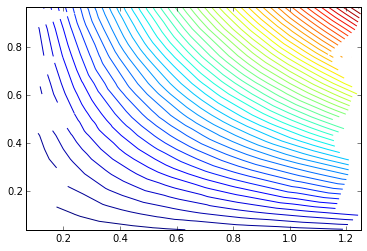

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt

x = sp.tile(sp.rand(25,1),(1,20))
x = x + 0.3*sp.rand(25,20)
x = np.sort(x,axis=0)

y = sp.tile(sp.rand(1,20),(25,1))
y = np.sort(y,axis=1)
z = x*y


plt.contour(x,y,z,50)